/var/folders/js/_m5r698x29j4dvr0w18h6jdm0000gn/T/ipykernel_90061/3777144180.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Years with NaN values: [2021]
52.782934279853016
Q1: 16.74033345730031, Q3: 34.60592853216895, IQR: 17.865595074868644
41.381605819145946
    scaled_avg_daily_smoke_impact  year  total_acres_burned  fire_year  \
0                       13.223345  1985        1.485882e+05     1985.0   
3                       22.046619  1988        3.646471e+05     1988.0   
4                       13.755830  1989        9.559396e+04     1989.0   
5                        8.653858  1990        7.796472e+04     1990.0   
7                       10.522113  1992        6.715140e+04     1992.0   
8                       13.372834  1993        1.669350e+05     1993.0   
9                       24.890273  1994        3.350621e+05     1994.0   
10                       9.156539  1995        1.789948e+05     1995.0   
11                      41.381606  1996        8.200648e+05     1996.0   
12                      13.160343  1997        1.488227e+05     1997.0   
13                      16.820036  1998        5

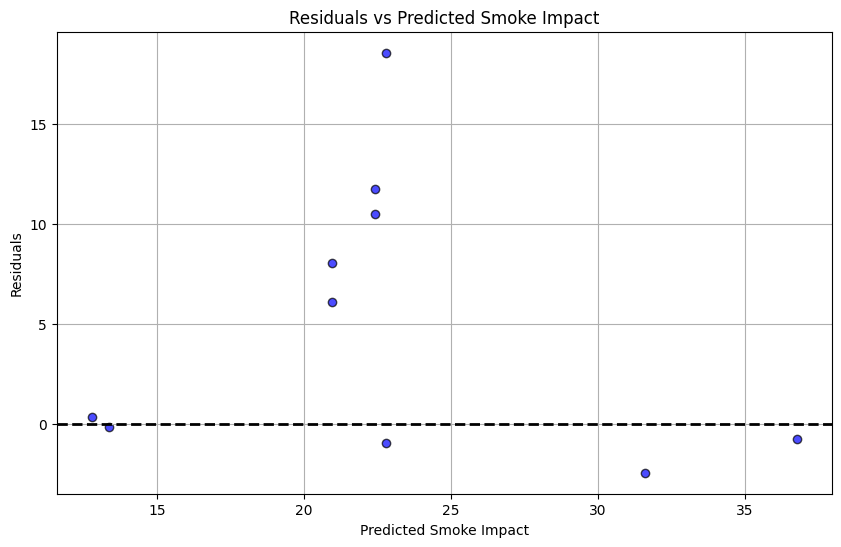

In [ ]:
# %% [markdown]
# ## Update to include info about calculation steps

# %%
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
import pickle
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.utils import resample

with open('intermediate_file_paths.json') as output_path_file:
    output_paths = json.load(output_path_file)

SI_PER_FIRE_INPUT_PATH = output_paths.get('stage1_si_per_fire_csv')
SCALED_SI_PER_YEAR_INPUT_PATH = output_paths.get('stage2_scaled_si_per_year_csv')

# Load dataset
yearly_smoke_impact_df = pd.read_csv(SCALED_SI_PER_YEAR_INPUT_PATH)
si_per_fire_df = pd.read_csv(SI_PER_FIRE_INPUT_PATH)

# Define weights for 'total_acres_burned' and 'distance'
weights = {'total_acres_burned': 1, 'distance': 1}

# Calculate the average distance per year
avg_dist_df = si_per_fire_df.groupby('fire_year').agg(
    avg_dist_from_city=('distance', 'mean')
).reset_index()

# Filter data to include only years after 1984
yearly_smoke_impact_filtered_df = yearly_smoke_impact_df[yearly_smoke_impact_df['year'] > 1984]
filtered_avg_dist_df = avg_dist_df[avg_dist_df['fire_year'] > 1984]

# Prepare data for prediction using original data (without moving average)
combined_df = yearly_smoke_impact_filtered_df[['scaled_avg_daily_smoke_impact', 'year', 'total_acres_burned']].merge(
    filtered_avg_dist_df[['fire_year', 'avg_dist_from_city']],
    left_on='year', right_on='fire_year', how='left'
)

# Identify which years have NaN values
na_years = combined_df[combined_df.isna().any(axis=1)]['year'].unique()
print(f"Years with NaN values: {na_years}")

# Remove rows with NaN values in features or labels
combined_df = combined_df.dropna()

print(combined_df['scaled_avg_daily_smoke_impact'].max())

# Remove outliers using Interquartile Range (IQR) method
Q1 = combined_df['scaled_avg_daily_smoke_impact'].quantile(0.25)
Q3 = combined_df['scaled_avg_daily_smoke_impact'].quantile(0.75)
IQR = Q3 - Q1

print(f'Q1: {Q1}, Q3: {Q3}, IQR: {IQR}')
# combined_df = combined_df[(combined_df['scaled_avg_daily_smoke_impact'] >= (Q1 - 1.2 * IQR)) & 
#                           (combined_df['scaled_avg_daily_smoke_impact'] <= (Q3 + 1.2 * IQR))]

combined_df = combined_df[(combined_df['scaled_avg_daily_smoke_impact'] >= (Q1 - 0.5 * IQR)) & 
                          (combined_df['scaled_avg_daily_smoke_impact'] <= (Q3 + 0.5 * IQR))]



print(combined_df['scaled_avg_daily_smoke_impact'].max())

# Check if there are enough samples left after filtering
if combined_df.shape[0] == 0:
    raise ValueError("No samples left after filtering for outliers and NaN values. Consider relaxing the filtering criteria.")

# Normalize total acres burned and distance
combined_df['total_acres_burned_normalized'] = combined_df['total_acres_burned'] / combined_df['total_acres_burned'].max()
combined_df['distance_normalized'] = combined_df['avg_dist_from_city'] / 650

# Apply weights to the relevant predictor variables
combined_df['total_acres_burned_weighted'] = combined_df['total_acres_burned_normalized'] * weights['total_acres_burned']
combined_df['distance_weighted'] = combined_df['distance_normalized'] * weights['distance']

print(combined_df)

# Prepare the features and target variable
features = combined_df[['total_acres_burned_weighted', 'distance_weighted']]
labels = combined_df['scaled_avg_daily_smoke_impact'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Define Gradient Boosting Regressor
model = GradientBoostingRegressor(random_state=42)

# Define hyperparameter grid for Grid Search
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Grid Search with Cross-Validation
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best estimator from Grid Search
model = grid_search.best_estimator_

#model.fit(X_train, y_train)

# Bootstrapping
# bootstrap_iterations = 100
# bootstrap_mse_scores = []
# bootstrap_r2_scores = []

# Set a fixed random state for the entire process
random_state = 42

# Bootstrapping with a fixed random seed for consistency
bootstrap_iterations = 100
bootstrap_mse_scores = []
bootstrap_r2_scores = []

kf = KFold(n_splits=3, shuffle=True, random_state=random_state)

for _ in range(bootstrap_iterations):
    # Resample without resetting the random state each time, allowing randomness within the fixed random state context
    X_resampled, y_resampled = resample(features, labels, random_state=random_state)
    
    # Evaluate the model
    mse_scores = cross_val_score(model, X_resampled, y_resampled, cv=kf, scoring='neg_mean_squared_error')
    r2_scores = cross_val_score(model, X_resampled, y_resampled, cv=kf, scoring='r2')
    
    bootstrap_mse_scores.append(-np.mean(mse_scores))
    bootstrap_r2_scores.append(np.mean(r2_scores))

# Results
print(f"\nBootstrapped Cross-Validation Mean Squared Error (MSE): {np.mean(bootstrap_mse_scores)}")
print(f"Bootstrapped Cross-Validation R-squared (R2): {np.mean(bootstrap_r2_scores)}")



# random_state = 42
# for _ in range(bootstrap_iterations):
#     X_resampled, y_resampled = resample(features, labels, random_state=random_state)
#     random_state += 1
#     kf = KFold(n_splits=3, shuffle=True, random_state=random_state)
#     mse_scores = cross_val_score(model, X_resampled, y_resampled, cv=kf, scoring='neg_mean_squared_error')
#     r2_scores = cross_val_score(model, X_resampled, y_resampled, cv=kf, scoring='r2')
#     bootstrap_mse_scores.append(-np.mean(mse_scores))
#     bootstrap_r2_scores.append(np.mean(r2_scores))

print(f"Bootstrapped Cross-Validation Mean Squared Error (MSE): {np.mean(bootstrap_mse_scores)}")
print(f"Bootstrapped Cross-Validation R-squared (R2): {np.mean(bootstrap_r2_scores)}")

# Model already fitted using Grid Search

# Save the trained model to a file using pickle
with open('trained_gradient_boosting_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)


# Load the trained model for predictions using pickle
# with open('trained_gradient_boosting_model.pkl', 'rb') as model_file:
#     model = pickle.load(model_file)

# Predict smoke estimates for the test set
y_pred = model.predict(X_test)

# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue', edgecolors='k', alpha=0.7)
plt.axhline(y=0, color='k', linestyle='--', lw=2)
plt.xlabel('Predicted Smoke Impact')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Smoke Impact')
plt.grid(True)
plt.show()


/var/folders/js/_m5r698x29j4dvr0w18h6jdm0000gn/T/ipykernel_92863/791130590.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Years with NaN values: [2021]
Max of scaled_avg_daily_smoke_impact before filtering outliers:
52.782934279853016
Q1: 16.74033345730031, Q3: 34.60592853216895, IQR: 17.865595074868644
Max of scaled_avg_daily_smoke_impact after filtering outliers:
41.381605819145946

Before applying weights:
   total_acres_burned_normalized  distance_normalized
0                       0.030576             0.687161
3                       0.075037             0.616994
4                       0.019671             0.603956
5                       0.016044             0.534834
7                       0.013818             0.588911

After applying weights:
   total_acres_burned_weighted  distance_weighted
0                     0.030576           0.687161
3                     0.075037           0.616994
4                     0.019671           0.603956
5                     0.016044           0.534834
7                     0.013818           0.588911

Features used for training:
   total_acres_burned_weighted 

/Users/debbiesubocz/anaconda3/envs/512_proj/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


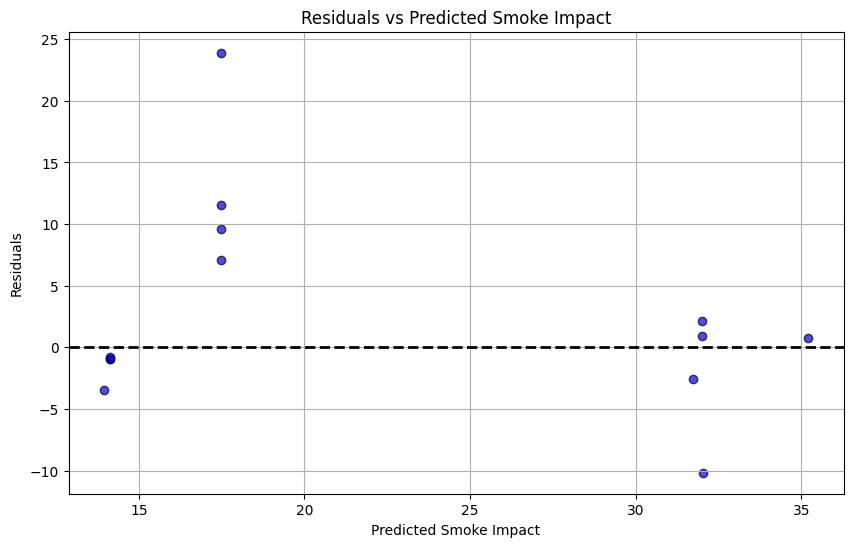

In [1]:
# %% [markdown]
# ## Update to include info about calculation steps

# %%
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
import pickle
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.utils import resample

with open('intermediate_file_paths.json') as output_path_file:
    output_paths = json.load(output_path_file)

SI_PER_FIRE_INPUT_PATH = output_paths.get('stage1_si_per_fire_csv')
SCALED_SI_PER_YEAR_INPUT_PATH = output_paths.get('stage2_scaled_si_per_year_csv')

# Load dataset
yearly_smoke_impact_df = pd.read_csv(SCALED_SI_PER_YEAR_INPUT_PATH)
si_per_fire_df = pd.read_csv(SI_PER_FIRE_INPUT_PATH)

# Define weights for 'total_acres_burned' and 'distance'
#weights = {'total_acres_burned': 10, 'distance': 5}
acres_weight = 1
dist_weight = 1

# Calculate the average distance per year
avg_dist_df = si_per_fire_df.groupby('fire_year').agg(
    avg_dist_from_city=('distance', 'mean')
).reset_index()

# Filter data to include only years after 1984
yearly_smoke_impact_filtered_df = yearly_smoke_impact_df[yearly_smoke_impact_df['year'] > 1984]
filtered_avg_dist_df = avg_dist_df[avg_dist_df['fire_year'] > 1984]

# Prepare data for prediction using original data (without moving average)
combined_df = yearly_smoke_impact_filtered_df[['scaled_avg_daily_smoke_impact', 'year', 'total_acres_burned']].merge(
    filtered_avg_dist_df[['fire_year', 'avg_dist_from_city']],
    left_on='year', right_on='fire_year', how='left'
)

# Identify which years have NaN values
na_years = combined_df[combined_df.isna().any(axis=1)]['year'].unique()
print(f"Years with NaN values: {na_years}")

# Remove rows with NaN values in features or labels
combined_df = combined_df.dropna()

print("Max of scaled_avg_daily_smoke_impact before filtering outliers:")
print(combined_df['scaled_avg_daily_smoke_impact'].max())

# Remove outliers using Interquartile Range (IQR) method
Q1 = combined_df['scaled_avg_daily_smoke_impact'].quantile(0.25)
Q3 = combined_df['scaled_avg_daily_smoke_impact'].quantile(0.75)
IQR = Q3 - Q1

print(f'Q1: {Q1}, Q3: {Q3}, IQR: {IQR}')
combined_df = combined_df[(combined_df['scaled_avg_daily_smoke_impact'] >= (Q1 - 0.5 * IQR)) & 
                          (combined_df['scaled_avg_daily_smoke_impact'] <= (Q3 + 0.5 * IQR))]

print("Max of scaled_avg_daily_smoke_impact after filtering outliers:")
print(combined_df['scaled_avg_daily_smoke_impact'].max())

# Check if there are enough samples left after filtering
if combined_df.shape[0] == 0:
    raise ValueError("No samples left after filtering for outliers and NaN values. Consider relaxing the filtering criteria.")

# Normalize total acres burned and distance
combined_df['total_acres_burned_normalized'] = combined_df['total_acres_burned'] / combined_df['total_acres_burned'].max()
combined_df['distance_normalized'] = combined_df['avg_dist_from_city'] / 650

# Print before applying weights
print("\nBefore applying weights:")
print(combined_df[['total_acres_burned_normalized', 'distance_normalized']].head())

combined_df['total_acres_burned_weighted'] = combined_df['total_acres_burned_normalized'].apply(lambda x: x * acres_weight)

combined_df['distance_weighted'] = combined_df['distance_normalized'].apply(lambda x: x * dist_weight)

# Apply weights to the relevant predictor variables
# combined_df['total_acres_burned_weighted'] = combined_df['total_acres_burned_normalized'] * weights['total_acres_burned']
# combined_df['distance_weighted'] = combined_df['distance_normalized'] * weights['distance']

# Print after applying weights
print("\nAfter applying weights:")
print(combined_df[['total_acres_burned_weighted', 'distance_weighted']].head())

# Prepare the features and target variable
features = combined_df[['total_acres_burned_weighted', 'distance_weighted']]
labels = combined_df['scaled_avg_daily_smoke_impact'].values

# Print a few rows of features to verify
print("\nFeatures used for training:")
print(features.head())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.4, random_state=42)

# Define Gradient Boosting Regressor
model = GradientBoostingRegressor(random_state=42)

# Define hyperparameter grid for Grid Search
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Grid Search with Cross-Validation
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best estimator from Grid Search
model = grid_search.best_estimator_

# Set a fixed random state for the entire process
random_state = 42

# Bootstrapping with a fixed random seed for consistency
bootstrap_iterations = 100
bootstrap_mse_scores = []
bootstrap_r2_scores = []

kf = KFold(n_splits=3, shuffle=True, random_state=random_state)

for _ in range(bootstrap_iterations):
    # Resample the data to create new bootstrap samples
    X_resampled, y_resampled = resample(features, labels, random_state=random_state)
    
    # Convert to numpy arrays if they are DataFrames or Series
    if isinstance(X_resampled, pd.DataFrame):
        X_resampled = X_resampled.to_numpy()
    if isinstance(y_resampled, pd.Series):
        y_resampled = y_resampled.to_numpy()
    
    mse_scores = []
    r2_scores = []
    
    # Cross-validation with a fresh model for each fold
    for train_index, test_index in kf.split(X_resampled):
        X_train_fold, X_test_fold = X_resampled[train_index], X_resampled[test_index]
        y_train_fold, y_test_fold = y_resampled[train_index], y_resampled[test_index]
        
        # Create a new instance of the model
        model = GradientBoostingRegressor(random_state=42)
        
        # Fit model on the current fold's training data
        #model.fit(X_train_fold, y_train_fold)

        grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train_fold, y_train_fold)

        # Best estimator from Grid Search
        model = grid_search.best_estimator_
        
        # Calculate scores on the current fold's test data
        y_pred_fold = model.predict(X_test_fold)
        mse_scores.append(np.mean((y_test_fold - y_pred_fold) ** 2))
        r2_scores.append(model.score(X_test_fold, y_test_fold))
    
    # Store the mean MSE and R2 for this bootstrap iteration
    bootstrap_mse_scores.append(np.mean(mse_scores))
    bootstrap_r2_scores.append(np.mean(r2_scores))

# Output results
print(f"\nBootstrapped Cross-Validation Mean Squared Error (MSE): {np.mean(bootstrap_mse_scores)}")
print(f"Bootstrapped Cross-Validation R-squared (R2): {np.mean(bootstrap_r2_scores)}")

 

# for _ in range(bootstrap_iterations):
#     # Resample without resetting the random state each time, allowing randomness within the fixed random state context
#     X_resampled, y_resampled = resample(features, labels, random_state=random_state)
    
#     # Evaluate the model
#     mse_scores = cross_val_score(model, X_resampled, y_resampled, cv=kf, scoring='neg_mean_squared_error')
#     r2_scores = cross_val_score(model, X_resampled, y_resampled, cv=kf, scoring='r2')
    
#     bootstrap_mse_scores.append(-np.mean(mse_scores))
#     bootstrap_r2_scores.append(np.mean(r2_scores))

print(f"\nBootstrapped Cross-Validation Mean Squared Error (MSE): {np.mean(bootstrap_mse_scores)}")
print(f"Bootstrapped Cross-Validation R-squared (R2): {np.mean(bootstrap_r2_scores)}")

# Model already fitted using Grid Search

# Save the trained model to a file using pickle
with open('trained_gradient_boosting_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# Predict smoke estimates for the test set
y_pred = model.predict(X_test)

# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue', edgecolors='k', alpha=0.7)
plt.axhline(y=0, color='k', linestyle='--', lw=2)
plt.xlabel('Predicted Smoke Impact')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Smoke Impact')
plt.grid(True)
plt.show()


/var/folders/js/_m5r698x29j4dvr0w18h6jdm0000gn/T/ipykernel_96995/1291730082.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Years with NaN values: [2021]
Max of scaled_avg_daily_smoke_impact before filtering outliers:
52.782934279853016
Q1: 16.74033345730031, Q3: 34.60592853216895, IQR: 17.865595074868644
Max of scaled_avg_daily_smoke_impact after filtering outliers:
41.381605819145946

Before applying weights:
   total_acres_burned_normalized  distance_normalized
0                       0.030576             0.687161
3                       0.075037             0.616994
4                       0.019671             0.603956
5                       0.016044             0.534834
7                       0.013818             0.588911

After applying weights:
   total_acres_burned_weighted  distance_weighted
0                     0.030576           0.687161
3                     0.075037           0.616994
4                     0.019671           0.603956
5                     0.016044           0.534834
7                     0.013818           0.588911

Features used for training:
   total_acres_burned_weighted 

/Users/debbiesubocz/anaconda3/envs/512_proj/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


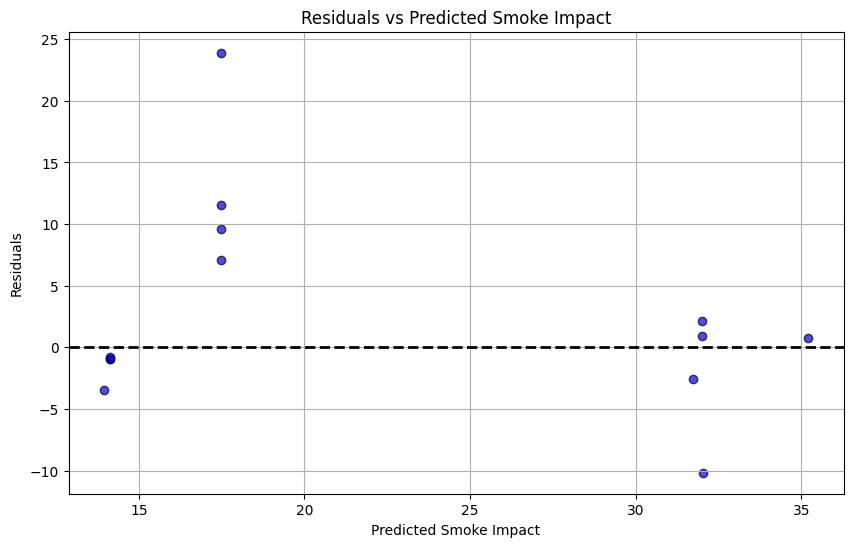

In [1]:
# %% [markdown]
# ## Update to include info about calculation steps

# %%
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
import pickle
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.utils import resample

with open('intermediate_file_paths.json') as output_path_file:
    output_paths = json.load(output_path_file)

SI_PER_FIRE_INPUT_PATH = output_paths.get('stage1_si_per_fire_csv')
SCALED_SI_PER_YEAR_INPUT_PATH = output_paths.get('stage2_scaled_si_per_year_csv')

# Load dataset
yearly_smoke_impact_df = pd.read_csv(SCALED_SI_PER_YEAR_INPUT_PATH)
si_per_fire_df = pd.read_csv(SI_PER_FIRE_INPUT_PATH)

# Define weights for 'total_acres_burned' and 'distance'
acres_weight = 1
dist_weight = 1

# Calculate the average distance per year
avg_dist_df = si_per_fire_df.groupby('fire_year').agg(
    avg_dist_from_city=('distance', 'mean')
).reset_index()

# Filter data to include only years after 1984
yearly_smoke_impact_filtered_df = yearly_smoke_impact_df[yearly_smoke_impact_df['year'] > 1984]
filtered_avg_dist_df = avg_dist_df[avg_dist_df['fire_year'] > 1984]

# Prepare data for prediction using original data (without moving average)
combined_df = yearly_smoke_impact_filtered_df[['scaled_avg_daily_smoke_impact', 'year', 'total_acres_burned']].merge(
    filtered_avg_dist_df[['fire_year', 'avg_dist_from_city']],
    left_on='year', right_on='fire_year', how='left'
)

# Identify which years have NaN values
na_years = combined_df[combined_df.isna().any(axis=1)]['year'].unique()
print(f"Years with NaN values: {na_years}")

# Remove rows with NaN values in features or labels
combined_df = combined_df.dropna()

print("Max of scaled_avg_daily_smoke_impact before filtering outliers:")
print(combined_df['scaled_avg_daily_smoke_impact'].max())

# Remove outliers using Interquartile Range (IQR) method
Q1 = combined_df['scaled_avg_daily_smoke_impact'].quantile(0.25)
Q3 = combined_df['scaled_avg_daily_smoke_impact'].quantile(0.75)
IQR = Q3 - Q1

print(f'Q1: {Q1}, Q3: {Q3}, IQR: {IQR}')
combined_df = combined_df[(combined_df['scaled_avg_daily_smoke_impact'] >= (Q1 - 0.5 * IQR)) & 
                          (combined_df['scaled_avg_daily_smoke_impact'] <= (Q3 + 0.5 * IQR))]

print("Max of scaled_avg_daily_smoke_impact after filtering outliers:")
print(combined_df['scaled_avg_daily_smoke_impact'].max())

# Check if there are enough samples left after filtering
if combined_df.shape[0] == 0:
    raise ValueError("No samples left after filtering for outliers and NaN values. Consider relaxing the filtering criteria.")

# Normalize total acres burned and distance
combined_df['total_acres_burned_normalized'] = combined_df['total_acres_burned'] / combined_df['total_acres_burned'].max()
combined_df['distance_normalized'] = combined_df['avg_dist_from_city'] / 650

# Print before applying weights
print("\nBefore applying weights:")
print(combined_df[['total_acres_burned_normalized', 'distance_normalized']].head())

combined_df['total_acres_burned_weighted'] = combined_df['total_acres_burned_normalized'] * acres_weight
combined_df['distance_weighted'] = combined_df['distance_normalized'] * dist_weight

# Print after applying weights
print("\nAfter applying weights:")
print(combined_df[['total_acres_burned_weighted', 'distance_weighted']].head())

# Prepare the features and target variable
features = combined_df[['total_acres_burned_weighted', 'distance_weighted']]
labels = combined_df['scaled_avg_daily_smoke_impact'].values

# Print a few rows of features to verify
print("\nFeatures used for training:")
print(features.head())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.4, random_state=42)

# Define Gradient Boosting Regressor
model = GradientBoostingRegressor(random_state=42)

# Define hyperparameter grid for Grid Search
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Grid Search with Cross-Validation
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best estimator from Grid Search
model = grid_search.best_estimator_

# Initialize variables to keep track of the best model and score
best_model = None
best_mse_score = float("inf")

# Bootstrapping with a fixed random seed for consistency
bootstrap_iterations = 100
bootstrap_mse_scores = []
bootstrap_r2_scores = []

random_state = 42

kf = KFold(n_splits=3, shuffle=True, random_state=random_state)

for _ in range(bootstrap_iterations):
    # Resample the data to create new bootstrap samples
    X_resampled, y_resampled = resample(features, labels, random_state=random_state)
    
    # Convert to numpy arrays if they are DataFrames or Series
    if isinstance(X_resampled, pd.DataFrame):
        X_resampled = X_resampled.to_numpy()
    if isinstance(y_resampled, pd.Series):
        y_resampled = y_resampled.to_numpy()
    
    mse_scores = []
    r2_scores = []
    
    # Cross-validation with a fresh model for each fold
    for train_index, test_index in kf.split(X_resampled):
        X_train_fold, X_test_fold = X_resampled[train_index], X_resampled[test_index]
        y_train_fold, y_test_fold = y_resampled[train_index], y_resampled[test_index]
        
        # Create a new instance of the model
        model = GradientBoostingRegressor(random_state=42)

        # Perform Grid Search to get the best estimator
        grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train_fold, y_train_fold)
        model = grid_search.best_estimator_
        
        # Calculate scores on the current fold's test data
        y_pred_fold = model.predict(X_test_fold)
        fold_mse = np.mean((y_test_fold - y_pred_fold) ** 2)
        mse_scores.append(fold_mse)
        r2_scores.append(model.score(X_test_fold, y_test_fold))
    
    # Store the mean MSE and R2 for this bootstrap iteration
    mean_mse = np.mean(mse_scores)
    mean_r2 = np.mean(r2_scores)
    bootstrap_mse_scores.append(mean_mse)
    bootstrap_r2_scores.append(mean_r2)
    
    # Update best model if the current one has the lowest mean MSE
    if mean_mse < best_mse_score:
        best_mse_score = mean_mse
        best_model = model

# Output results
print(f"\nBest Bootstrapped Cross-Validation Mean Squared Error (MSE): {best_mse_score}")
print(f"Bootstrapped Cross-Validation Average MSE across iterations: {np.mean(bootstrap_mse_scores)}")
print(f"Bootstrapped Cross-Validation Average R-squared (R2) across iterations: {np.mean(bootstrap_r2_scores)}")

# Save the best model to a file using pickle
with open('best_gradient_boosting_model.pkl', 'wb') as model_file:
    pickle.dump(best_model, model_file)

# Predict smoke estimates for the test set with the best model
y_pred = best_model.predict(X_test)

# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue', edgecolors='k', alpha=0.7)
plt.axhline(y=0, color='k', linestyle='--', lw=2)
plt.xlabel('Predicted Smoke Impact')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Smoke Impact')
plt.grid(True)
plt.show()
